In [1]:
import torch
from datafree.datasets import TinyImageNet
from torchvision import datasets, transforms as T
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

/u/alexdang/code/Fast-Datafree/.venv/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [4]:
# load validation split
data_root = os.path.join("data", 'tinyimagenet')
num_classes = 200
val_transform = T.Compose([
            T.ToTensor(),
            T.GaussianBlur(25),
])       
val_dst = TinyImageNet(data_root, train=False, transform=val_transform)
len(val_dst)

10000

transformed!
transformed!
transformed!
transformed!
transformed!
transformed!
transformed!
transformed!
transformed!


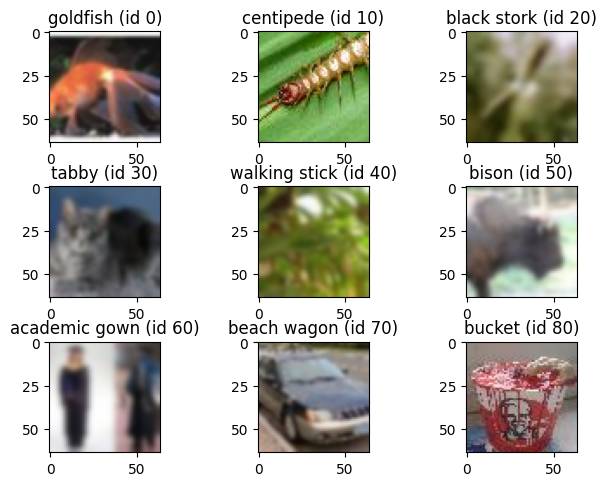

In [5]:
# look at validation images
rand_idx = torch.randint(0, len(val_dst), (9,)).tolist()
def show_images(image_idx):
    fig, axes = plt.subplots(3, 3)
    plt.tight_layout()
    for i, idx in enumerate(image_idx):
        img, label = val_dst[idx]
        ax = axes[i // 3, i % 3]
        description = val_dst.idx_to_description[label][1].split(',')[0]
        ax.set_title(f"{description} (id {label})")
        ax.imshow(img.permute([1, 2, 0]))
show_images([i*500 for i in range(9)])


In [4]:
# load model to test
from datafree.models.classifiers.resnet import resnet18
model = resnet18(num_classes)
pretrained_state_dict = torch.load('checkpoints/scratch/tinyimagenet_resnet18.pth', map_location='cpu')['state_dict']
processed_state_dict = {}
REMOVE_PREFIX = "module."
for k, v in pretrained_state_dict.items():
    new_k = k[len(REMOVE_PREFIX):] if REMOVE_PREFIX == k[:len(REMOVE_PREFIX)] else k
    processed_state_dict[new_k] = v
model.load_state_dict(processed_state_dict)
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [5]:
def evaluate(model, dst):
    model.eval()
    count_correct = 0
    batch_size = 128
    imgs = []
    labels = []
    for i in tqdm(range(len(dst))):
        img, label = dst[i]
        imgs.append(img)
        labels.append(label)
        if len(imgs) == batch_size:
            imgs = torch.stack(imgs).cuda()
            labels = torch.tensor(labels)
            output = model(imgs).cpu()
            output_labels = torch.argmax(output, dim=1)

            count_correct += torch.sum(output_labels == labels).item()
            imgs = []
            labels = []
    return count_correct / len(dst)
acc = evaluate(model, val_dst)
print(acc)

100%|██████████| 100000/100000 [01:34<00:00, 1052.65it/s]

0.99916
